Das vorliegende Notebook untersucht die molekulardynamische Wechselwirkung von zwei Sauerstoff-Atomen. Die Wechselwirkung der beiden Teilchen wird durch das Lennard-Jones-Potential beschrieben. \
Die Bewegung der beiden Atome ist auf eine Dimension (hier als x bezeichnet) beschränkt und erhält als wichtigste Eingabeparameter die Temperatur $T$, die Länge $L$ der Achse, auf derer sie sich bewegen können, die Gesamtzeit $t_{ges}$, in der die Bewegung der Teilchen untersucht wird und einen Anfangabstand der beiden Atome. Da die Lennard-Jones-Kraft am Anfang null sein soll, wird der Abstand auf $\sqrt[6]{2}\cdot\sigma_{O-O}=\sqrt[6]{2}\cdot3.265$ festgelegt.\

Den definierten Funktionen *LJkraft1D* für die Lennard-Jones-Kraft und *leapfrog1D* für den Leapfrog Algorithmus liegt der Code des Beispiel-Notebooks *Molekulardynamik_2D_Python.ipynb* zugrunde.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
L = 100    # Kantenlänge der 1D-"Box" in Angstrom
T5 = 5    # Temperatur in K.
T40 = 40    # Temperatur in K.
T80 = 80    # Temperatur in K.
tges = 20        # Gesamtzeit in ps
tau = 0.01     # Schrittweite
abst = 3.265*(2**(1/6))  #Abstand der Teilchen von einander, Lennard-Jones-Kraft bei 2^(1/6)*sigma(O-O) gleich null

N = 2 # Teilchenzahl
x = np.array([0, 0+abst]) #Anfangspositionen
m = 16*np.ones(N) # beide Teilchen sind O-Atome.
Z = 8*np.ones(N,dtype=int) # beide Teilchen sind O-Atome.
vx5 = np.sqrt(T5/m)  #Geschwindigkeit für T = 5K
vx40 = np.sqrt(T40/m) #Geschwindigkeit für T = 40K
vx80 = np.sqrt(T80/m) #Geschwindigkeit für T = 80K

In [3]:
def LJkraft1D(x,Z,periodic=0,Lx=25):
    # Wir extrahieren die Anzahl der Teilchen und allokieren Matrizen für die
    # x- Komponente der Kraft:
    N=x.shape[0]
    fx=np.zeros(N) 
      
    # Die sigma-Matrix und epsk-Matrix beinhalten die Interaktionen für
    # Elemente untereinander. Wir verwenden einfach die Werte für Argon für
    # jede mögliche Interaktion, und passen diese für diejenigen Interaktionen
    # an, die wir wissen:
    sigMatrix  = 3.405*np.ones((103,103))
    epskMatrix = 119.8*np.ones((103,103))
    epskMatrix[2,2] = 10.9   
    sigMatrix[2,2] = 2.640 # He-He
    epskMatrix[8,8] = 72.2   
    sigMatrix[8,8] = 3.265 # O-O
    epskMatrix[2,8] = 28.0
    sigMatrix[2,8] = 2.952 # He-O
    epskMatrix[8,2] = epskMatrix[2,8]
    sigMatrix[8,2] = sigMatrix[2,8]  # He-O = O-He
    epskMatrix[18,8] = 93.0   
    sigMatrix[18,8] = 3.335 # Ar-O
    epskMatrix[8,18] = epskMatrix[18,8]   
    sigMatrix[8,18] = sigMatrix[18,8]  # Ar-O = O-Ar
    # Wir generieren auch Werte für Ar-He (Mittelwert von He-He und Ar-Ar):
    epskMatrix[2,18] = 0.5*(epskMatrix[2,2]+epskMatrix[18,18]) # He-Ar
    sigMatrix[2,18]  = 0.5*(sigMatrix[2,2]+sigMatrix[18,18]) # He-Ar
    epskMatrix[18,2] = epskMatrix[2,18]
    sigMatrix[18,2] = sigMatrix[2,18]  # Ar-He = He-Ar

    # Jetzt loopen wir über Paare von verschiedenen Teilchen. Indem wir nur
    # Paare mit i<j betrachten, sorgen wir dafür, dass jedes Paar 1 mal dran ist:
    for i in range(0,N-1):
        for j in range(i+1,N):
            # Wenn periodic=0, dann liefern diese beiden loops einfach nur
            # offsX = 0 und offsY = 0. Wenn periodic = 1, dann loopen wir hier
            # über 9 benachbarte Zellen und berücksichtigen somit auch die 
            # Krafteinwirkung der Atome in jeder dieser Zellen:
            for offsX in range(-periodic,periodic+1):
                for offsY in range(-periodic,periodic+1):
                    xij  = x[j]+Lx*offsX-x[i];
                    sig2 = sigMatrix[Z[i],Z[j]]**2
                    r2=xij**2 # Abstand^2
                    
                    # fac=4*epsk*(12/r^14-6/r^8):
                    if (r2< 1):
                        r2 = 1
                        #print("sig2 = ",sig2,"r2=",r2,i,j,offsX,offsY)
                    
                    ri2=sig2/r2
                    LJfaktor=24.0*epskMatrix[Z[i],Z[j]]*(ri2**4)*(2.0*(ri2**3)-1.0)/sig2 
                    fx[i] -= xij*LJfaktor # Beitrag dieser Paarkraft AUF i
                    fx[j] += xij*LJfaktor # Beitrag dieser Paarkraft AUF j
    

    return fx

In [11]:
def leapfrog1D(x,T,Z,m,Lx,tau,nstep,periodic):

    # Die Teilchenzahl ist einfach die Länge eines der input Vektoren
    N=x.shape[0] # Teilchenzahl
    nstep = int(nstep)
    
    # Wir definieren auch die Matrizen, die die Evolution des Systems
    # Beschreiben. Um die Anfangsgeschwindigkeit zu bei t = tau/2 zu erhalten,
    # müssen wir um einen halben Zeitschritt vorwärts projizieren.
    X = np.zeros((N,nstep+1)) 
    VX= np.zeros((N,nstep+1)) 
    X[:,0]= x # Startwerte
    fx = LJkraft1D(x,Z,periodic,Lx)
    VX[:,0] = np.sqrt(T/m)+0.5*tau*fx/m 

    # Der Leapfrog Loop
    for n in range(0,nstep):
        X[:,n+1]=X[:,n]+tau*VX[:,n] # Orte: n*tau -> (n+1)*tau
        # Reflektieren am Rand der 2D Box:
        for i in range(0,N):
            if (Lx > 0):
                if (X[i,n+1]<0): 
                    X[i,n+1]= -X[i,n+1]
                    VX[i,n]=-VX[i,n]
                if (X[i,n+1]>Lx): 
                    X[i,n+1]=2*Lx-X[i,n+1] 
                    VX[i,n]=-VX[i,n]
        
        fx=LJkraft1D(X[:,n+1],Z,periodic,Lx)
        VX[:,n+1]=VX[:,n]+tau*fx/m  # Impulse: (n+1/2)*tau -> (n+3/2)*tau

    # Da die Geschwindigkeit am Ende für einen halben zeitschritt früher
    # berechnet wurde, als die Position, müssen wir diese noch einen
    # halben Zeitschritt weiter propagieren:
    fx=LJkraft1D(X[:,-1],Z,periodic,Lx)
    VX[:,-1]=VX[:,-1]-0.5*tau*fx/m
    
    x1 = X[0,:] #Teilchen 1: holt sich die gesamte erste Zeile aus der Matrix mit den Positionsdaten
    x2 = X[1,:] #Teilchen 2: holt sich die gesamte zweite Zeile

    nstep = np.round(tges/tau) # Anzahl Schritte
    t = np.linspace(0,tges,int(nstep+1)) #Festlegung der Zeitachse (0, Gesamtzeit, Anzahl Zeitschritte)
    
    return t, x1, x2

In [12]:
nstep = np.round(tges/tau)

#Aufrufen der leapfrog1D-Funktion, um die jeweiligen Bewegungsdaten der Teilchen zu erhalten
t, x1_5, x2_5 = leapfrog1D(x,T5,Z,m,L,tau,nstep,0) #für T=5K
t, x1_40, x2_40 = leapfrog1D(x,T40,Z,m,L,tau,nstep,0) #für T=40K
t, x1_80, x2_80 = leapfrog1D(x,T80,Z,m,L,tau,nstep,0) #für T=80K

In [13]:
#Berechnung des Abstandes der Teilchen
#Berechnung des Schwerpunktes der beiden Teilchen
dif5 = np.abs(x1_5-x2_5)
sp5 = (x1_5+x2_5)/2

dif40 = np.abs(x1_40-x2_40)
sp40 = (x1_40+x2_40)/2

dif80 = np.abs(x1_80-x2_80)
sp80 = (x1_80+x2_80)/2

Text(0.5, 0.98, 'Temperatur = 5 K')

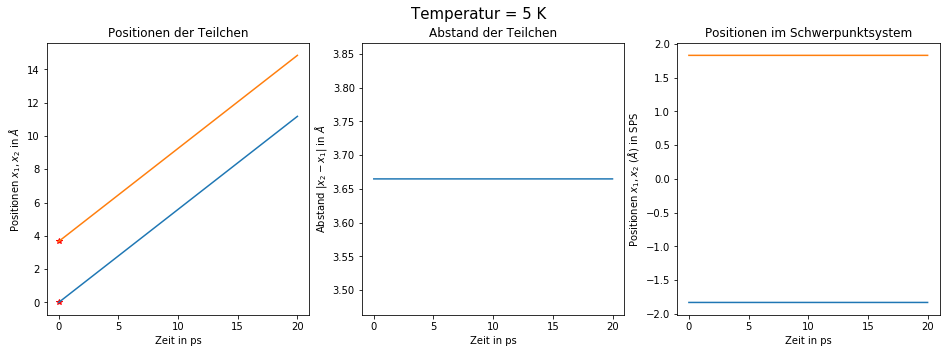

In [14]:
#Plotten der Daten: 1. Plot x(t), 2. Plot |x1-x2|(t), 3. Plot x(t)-x_sp(t)
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].plot(np.array([0,0]),x,'r*') #Anfangspositionen
axs[0].plot(t, x1_5)
axs[0].plot(t, x2_5)
axs[0].set_title("Positionen der Teilchen")
axs[0].set(xlabel="Zeit in ps", ylabel="Positionen $x_1, x_2$ in $\AA$")
axs[1].plot(t, dif5)
axs[1].set_title("Abstand der Teilchen")
axs[1].set(xlabel="Zeit in ps", ylabel="Abstand $|x_2-x_1|$ in $\AA$")
axs[2].plot(t, x1_5-sp5)
axs[2].plot(t, x2_5-sp5)
axs[2].set_title("Positionen im Schwerpunktsystem")
axs[2].set(xlabel="Zeit in ps", ylabel="Positionen $x_1, x_2$ ($\AA$) in SPS")
fig.suptitle('Temperatur = 5 K', size=15)

Text(0.5, 0.98, 'Temperatur = 40 K')

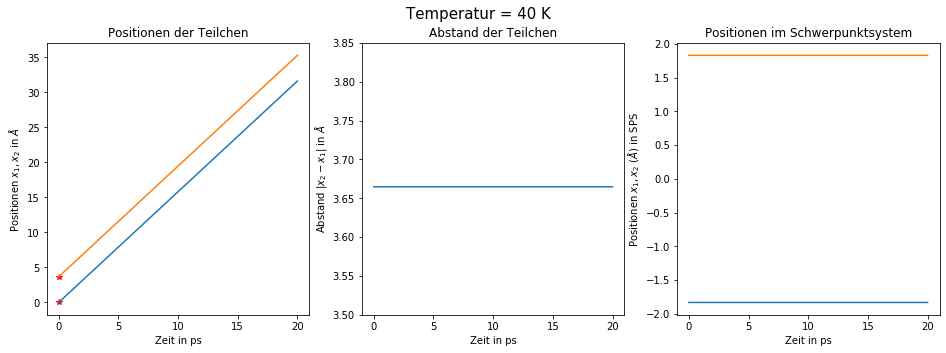

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].plot(np.array([0,0]),x,'r*')
axs[0].plot(t, x1_40)
axs[0].plot(t, x2_40)
axs[0].set_title("Positionen der Teilchen")
axs[0].set(xlabel="Zeit in ps", ylabel="Positionen $x_1, x_2$ in $\AA$")
axs[1].plot(t, dif40)
axs[1].set_title("Abstand der Teilchen")
axs[1].set(xlabel="Zeit in ps", ylabel="Abstand $|x_2-x_1|$ in $\AA$")
axs[1].set_ylim(3.5,3.85)
axs[2].plot(t, x1_40-sp40)
axs[2].plot(t, x2_40-sp40)
axs[2].set_title("Positionen im Schwerpunktsystem")
axs[2].set(xlabel="Zeit in ps", ylabel="Positionen $x_1, x_2$ ($\AA$) in SPS")
fig.suptitle('Temperatur = 40 K', size=15)

Text(0.5, 0.98, 'Temperatur = 80 K')

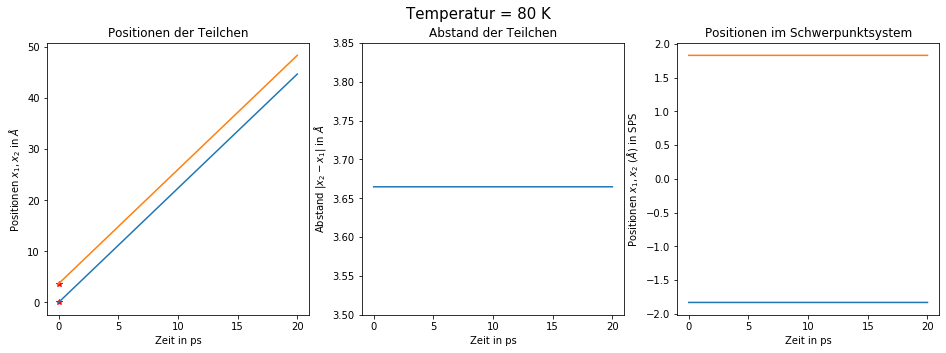

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].plot(np.array([0,0]),x,'r*')
axs[0].plot(t, x1_80)
axs[0].plot(t, x2_80)
axs[0].set_title("Positionen der Teilchen")
axs[0].set(xlabel="Zeit in ps", ylabel="Positionen $x_1, x_2$ in $\AA$")
axs[1].plot(t, dif80)
axs[1].set_title("Abstand der Teilchen")
axs[1].set(xlabel="Zeit in ps", ylabel="Abstand $|x_2-x_1|$ in $\AA$")
axs[1].set_ylim(3.5,3.85)
axs[2].plot(t, x1_80-sp80)
axs[2].plot(t, x2_80-sp80)
axs[2].set_title("Positionen im Schwerpunktsystem")
axs[2].set(xlabel="Zeit in ps", ylabel="Positionen $x_1, x_2$ ($\AA$) in SPS")
fig.suptitle('Temperatur = 80 K', size=15)

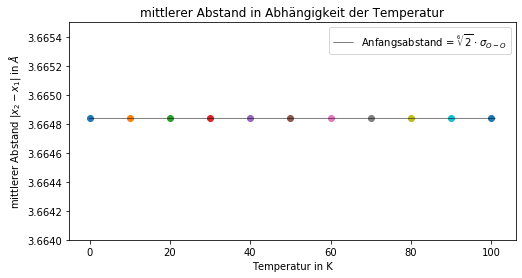

In [17]:
#Plotten des mittleren Abstandes in Abhängigkeit der Temperatur
#die schwarze Linie dient als Veranschaulichung, dass der Abstand mit der Zeit nicht vom Anfangsabstand abweicht
w = 3.265*(2**(1/6))*np.ones(10000)
fig = plt.figure(figsize=(8,4))
for i in range(0,101,10):
    t, x1, x2 = leapfrog1D(x,i,Z,m,L,tau,nstep,0)
    mean_abst = np.mean(np.abs(x1-x2))
    plt.scatter(i, mean_abst, marker='o')
plt.plot(np.linspace(0,101,10000), w, linewidth=0.5, color='k', label='Anfangsabstand = $\sqrt[6]{2}\cdot\sigma_{O-O}$')
plt.title("mittlerer Abstand in Abhängigkeit der Temperatur")
plt.xlabel("Temperatur in K")
plt.legend(loc='best')
plt.ylabel("mittlerer Abstand $|x_2-x_1|$ in $\AA$")
plt.ylim(3.664, 3.6655)
plt.show()

In der Darstellung des mittleren Abstandes der beiden Sauerstoff-Atome in Abhängigkeit der Temperatur ist, wie auch in den obigen Grafiken, ein sich nicht verändernder Abstand zu erkennen. Dies war nicht anders zu erwarten, da sich die Teilchen mit exakt gleicher Geschwindigkeit in die gleiche Richtung bewegen und somit ohne äußere Einwirkung den Abstand halten. Daran ändern könnte nur die Lennard-Jones-Kraft etwas. Da als Anfangsbedingung diese jedoch auf null gesetzt wurde und nur vom Abstand der Teilchen abhängt, bleibt sie auch fortwährend null und alles bleibt beim Alten...